# Load metadata

In [12]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import anndata
import scanpy as sc
import scanpy.external as sce
from itertools import islice, cycle
from sklearn.preprocessing import normalize

from ALLCools.clustering import tsne, significant_pc_test, filter_regions, remove_black_list_region, lsi, binarize_matrix
from ALLCools.plot import *

In [2]:
import glob
metafile = "/gale/netapp/DoD/wenliang/projects/05.COVID/00.data/cell_metadata.csv"
metadata = pd.read_csv(metafile, index_col=0)
metadata

Plate PCRIndex  MultiplexGroup RandomIndex  \
uid                                                                         
Cov2_1_1-2-A17-A15          Cov2_1_1      A17               2         A15   
Cov2_1_1-2-A17-A16          Cov2_1_1      A17               2         A16   
Cov2_1_1-2-A17-A3           Cov2_1_1      A17               2          A3   
Cov2_1_1-2-A17-A4           Cov2_1_1      A17               2          A4   
Cov2_1_1-2-A17-B15          Cov2_1_1      A17               2         B15   
...                              ...      ...             ...         ...   
Cov2_7_2_6_1-2-I24-O4   Cov2_7_2_6_1      I24               2          O4   
Cov2_7_2_6_1-2-I24-P15  Cov2_7_2_6_1      I24               2         P15   
Cov2_7_2_6_1-2-I24-P16  Cov2_7_2_6_1      I24               2         P16   
Cov2_7_2_6_1-2-I24-P3   Cov2_7_2_6_1      I24               2          P3   
Cov2_7_2_6_1-2-I24-P4   Cov2_7_2_6_1      I24               2          P4   

                        Col384  Row384  R1InputReads  R1InputReadsBP  \
uid                                                                    
Cov2_1_1-2-A17-A15          14       0         11401         1535744   
Cov2_1_1-2-A17-A16          15       0       2570837       364582461   
Cov2_1_1-2-A17-A3            2       0       2647029       375916828   
Cov2_1_1-2-A17-A4            3       0       2590293       367629971   
Cov2_1_1-2-A17-B15          14       1         14120         1937642   
...                        ...     ...           ...             ...   
Cov2_7_2_6_1-2-I24-O4        3      14       2645385       376228408   
Cov2_7_2_6_1-2-I24-P15      14      15         45273         6289959   
Cov2_7_2_6_1-2-I24-P16      15      15         23444         3272898   
Cov2_7_2_6_1-2-I24-P3        2      15       2927233       416502489   
Cov2_7_2_6_1-2-I24-P4        3      15       2720744       387115008   

                        R1WithAdapters  R1QualTrimBP  ...   mCGFrac  mCCCmC  \
uid                                                   ...                     
Cov2_1_1-2-A17-A15                  38         13980  ...  0.778708     499   
Cov2_1_1-2-A17-A16                2489        800411  ...  0.805108   19218   
Cov2_1_1-2-A17-A3                 2637        790579  ...  0.781100   20844   
Cov2_1_1-2-A17-A4                 2310        717654  ...  0.594314   24556   
Cov2_1_1-2-A17-B15                  38         15416  ...  0.763731     573   
...                                ...           ...  ...       ...     ...   
Cov2_7_2_6_1-2-I24-O4             1602        600239  ...  0.823217   19257   
Cov2_7_2_6_1-2-I24-P15              43         12388  ...  0.793427      51   
Cov2_7_2_6_1-2-I24-P16              25          6334  ...  0.885057      72   
Cov2_7_2_6_1-2-I24-P3             2063        672934  ...  0.836074   21357   
Cov2_7_2_6_1-2-I24-P4             1835        545471  ...  0.824711   19897   

                        mCCCCov  mCCCFrac  GenomeCov  CellInputReadPairs  \
uid                                                                        
Cov2_1_1-2-A17-A15          901  0.553829   0.000026               11401   
Cov2_1_1-2-A17-A16      3486598  0.005512   0.074503             2570837   
Cov2_1_1-2-A17-A3       3506349  0.005945   0.074977             2647029   
Cov2_1_1-2-A17-A4       3471739  0.007073   0.074358             2590293   
Cov2_1_1-2-A17-B15         1084  0.528598   0.000030               14120   
...                         ...       ...        ...                 ...   
Cov2_7_2_6_1-2-I24-O4   3359905  0.005731   0.070406             2645385   
Cov2_7_2_6_1-2-I24-P15      562  0.090747   0.000013               45273   
Cov2_7_2_6_1-2-I24-P16      266  0.270677   0.000007               23444   
Cov2_7_2_6_1-2-I24-P3   3611210  0.005914   0.075056             2927233   
Cov2_7_2_6_1-2-I24-P4   3424368  0.005810   0.071404             2720744   

                        CellBarcodeRatio  FinalmCReads   cell_type      Sam

In [3]:
metadata = metadata[metadata['Sample'] != 'Cov2_7_2_6']

In [4]:
sampleInfo = pd.read_csv("../../00.data/metadata.tsv", sep="\t")
# sampleInfo['PlateID'] = sampleInfo['PlateID'].apply(lambda x: "OP_" + str(x))
id2condition = dict(zip(sampleInfo['Sample'], sampleInfo['Condition']))

metadata['condition'] = [id2condition[x] for x in metadata['Sample']]

/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Filtering

/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


19452 / 19494 cells (99.8%) passed the MappingRate cutoff 0.5.


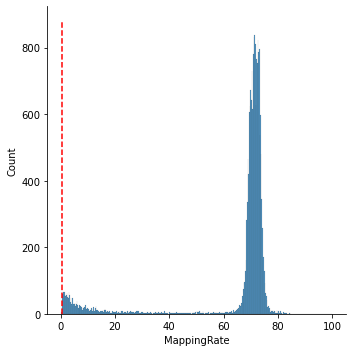

In [11]:
# Basic filtering parameters
mapping_rate_cutoff = 0.5
mapping_rate_col_name = 'MappingRate'  # Name may change
final_reads_cutoff = 500000
final_reads_col_name = 'FinalmCReads'  # Name may change
mcg_cutoff = 0.5
mcg_col_name = 'mCGFrac'  # Name may change

_cutoff = mapping_rate_cutoff
_col_name = mapping_rate_col_name

metadata['MappingRate'] = (metadata['R1MappingRate'] + metadata['R2MappingRate'])/2.0
total_cells = metadata.shape[0]
# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0, 100))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')

mapping_rate_judge = metadata[_col_name] > _cutoff
_passed_cells = mapping_rate_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

16849 / 19494 cells (86.4%) passed the FinalmCReads cutoff 500000.


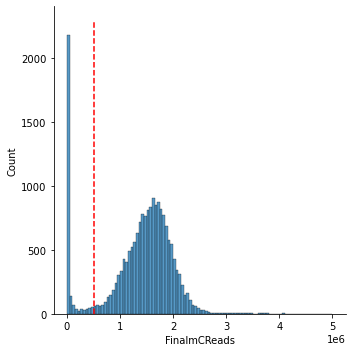

In [12]:
_cutoff = final_reads_cutoff
_col_name = final_reads_col_name

# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0, 5e6))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')

final_reads_judge = metadata[_col_name] > _cutoff
_passed_cells = final_reads_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

19366 / 19494 cells (99.3%) passed the mCGFrac cutoff 0.5.


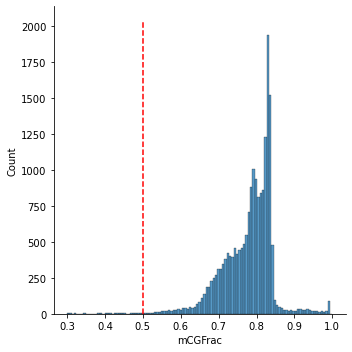

In [13]:
_cutoff = mcg_cutoff
_col_name = mcg_col_name

# plot distribution to make sure cutoff is appropriate
g = sns.displot(metadata[_col_name], binrange=(0.3, 1))
g.ax.plot((_cutoff, _cutoff), g.ax.get_ylim(), c='r', linestyle='--')

mcg_judge = metadata[_col_name] > _cutoff
_passed_cells = mcg_judge.sum()
print(
    f'{_passed_cells} / {total_cells} cells ({_passed_cells / total_cells * 100:.1f}%) '
    f'passed the {_col_name} cutoff {_cutoff}.')

In [14]:
judge = mapping_rate_judge & final_reads_judge & mcg_judge
passed_cells = judge.sum()
print(
    f'{passed_cells} / {total_cells} cells ({passed_cells / total_cells * 100:.1f}%) '
    f'passed all the filters.')

16835 / 19494 cells (86.4%) passed all the filters.


In [15]:
metadata_filtered = metadata[judge].copy()

metadata_filtered.to_csv('CellMetadata.PassQC.csv.gz')

# Decomposition Using mCG-5Kb Bins

In [16]:
metadata_path = 'CellMetadata.PassQC.csv.gz'
mcad_path = '../00.data/COVID.mcad'

# PC cutoff
pc_cutoff = 0.1

resolution = 1

In [17]:
metadata = pd.read_csv(metadata_path, index_col=0)
print(f'Metadata of {metadata.shape[0]} cells')
metadata.head()

Metadata of 16835 cells


Plate PCRIndex  MultiplexGroup RandomIndex  Col384  \
uid                                                                         
Cov2_1_1-2-A17-A16  Cov2_1_1      A17               2         A16      15   
Cov2_1_1-2-A17-A3   Cov2_1_1      A17               2          A3       2   
Cov2_1_1-2-A17-A4   Cov2_1_1      A17               2          A4       3   
Cov2_1_1-2-A17-B16  Cov2_1_1      A17               2         B16      15   
Cov2_1_1-2-A17-B3   Cov2_1_1      A17               2          B3       2   

                    Row384  R1InputReads  R1InputReadsBP  R1WithAdapters  \
uid                                                                        
Cov2_1_1-2-A17-A16       0       2570837       364582461            2489   
Cov2_1_1-2-A17-A3        0       2647029       375916828            2637   
Cov2_1_1-2-A17-A4        0       2590293       367629971            2310   
Cov2_1_1-2-A17-B16       1       2618822       370364927            2183   
Cov2_1_1-2-A17-B3        1       2688307       381790701            2565   

                    R1QualTrimBP  ...  mCCCCov  mCCCFrac  GenomeCov  \
uid                               ...                                 
Cov2_1_1-2-A17-A16        800411  ...  3486598  0.005512   0.074503   
Cov2_1_1-2-A17-A3         790579  ...  3506349  0.005945   0.074977   
Cov2_1_1-2-A17-A4         717654  ...  3471739  0.007073   0.074358   
Cov2_1_1-2-A17-B16        775174  ...  3670378  0.004704   0.078080   
Cov2_1_1-2-A17-B3         660282  ...  3648353  0.005686   0.078012   

                    CellInputReadPairs  CellBarcodeRatio  FinalmCReads  \
uid                                                                      
Cov2_1_1-2-A17-A16             2570837          0.003285       2076931   
Cov2_1_1-2-A17-A3              2647029          0.003383       2088272   
Cov2_1_1-2-A17-A4              2590293          0.003310       2071830   
Cov2_1_1-2-A17-B16             2618822          0.003347       2195173   
Cov2_1_1-2-A17-B3              2688307          0.003435       2177671   

                     cell_type  Sample  condition  MappingRate  
uid                                                             
Cov2_1_1-2-A17-A16  Other-cell  Cov2_1          C         72.5  
Cov2_1_1-2-A17-A3   Other-cell  Cov2_1          C         72.1  
Cov2_1_1-2-A17-A4   Other-cell  Cov2_1          C         72.7  
Cov2_1_1-2-A17-B16  Other-cell  Cov2_1          C         73.9  
Cov2_1_1-2-A17-B3   Other-cell  Cov2_1          C         72.8  

[5 rows x 69 columns]

In [18]:
mcad = anndata.read_h5ad(mcad_path)
mcad.X = mcad.X.astype(np.float32)

In [19]:
mcad = mcad[metadata.index]

In [20]:
mcad.obs = pd.concat([mcad.obs, metadata.reindex(mcad.obs_names)], axis=1)

In [21]:
binarize_matrix(mcad, cutoff=0.95)
# filter_regions(mcad, hypo_cutoff=6)
remove_black_list_region(mcad, black_list_path='/gale/netapp/DoD/wenliang/database/Blacklist/lists/hg38-blacklist.v2.bed.gz')

45816 features removed due to overlapping (bedtools intersect -f 0.2) with black list regions.


In [22]:
from scipy.stats import zscore

mcad.var['n_cell'] = mcad.X.sum(axis=0).A1
mcad._inplace_subset_var(mcad.var['n_cell']>5)
mcad._inplace_subset_var(np.abs(zscore(np.log(mcad.var['n_cell'])))<2)

In [23]:
exclude_chroms = mcad.var['chrom'].apply(lambda x: x not in ['chrX', 'chrY', 'chrM'])

In [24]:
mcad = mcad[:,exclude_chroms.index[exclude_chroms]]
mcad

View of AnnData object with n_obs × n_vars = 16835 × 487017
    obs: 'Plate', 'PCRIndex', 'MultiplexGroup', 'RandomIndex', 'Col384', 'Row384', 'R1InputReads', 'R1InputReadsBP', 'R1WithAdapters', 'R1QualTrimBP', 'R1TrimmedReads', 'R1TrimmedReadsBP', 'R1TrimmedReadsRate', 'R1UniqueMappedReads', 'R1MappingRate', 'R1UnmappedReads', 'R1UnuniqueMappedReads', 'R1OT', 'R1OB', 'R1CTOT', 'R1CTOB', 'R1TotalC', 'R1TotalmCGRate', 'R1TotalmCHGRate', 'R1TotalmCHHRate', 'R1MAPQFilteredReads', 'R1DuplicatedReads', 'R1DuplicationRate', 'R1FinalBismarkReads', 'R2InputReads', 'R2InputReadsBP', 'R2WithAdapters', 'R2QualTrimBP', 'R2TrimmedReads', 'R2TrimmedReadsBP', 'R2TrimmedReadsRate', 'R2UniqueMappedReads', 'R2MappingRate', 'R2UnmappedReads', 'R2UnuniqueMappedReads', 'R2OT', 'R2OB', 'R2CTOT', 'R2CTOB', 'R2TotalC', 'R2TotalmCGRate', 'R2TotalmCHGRate', 'R2TotalmCHHRate', 'R2MAPQFilteredReads', 'R2DuplicatedReads', 'R2DuplicationRate', 'R2FinalBismarkReads', 'mCHmC', 'mCHCov', 'mCHFrac', 'mCGmC', 'mCGCov', 

# 2. Clustering

In [25]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return

In [26]:
lsi(mcad, algorithm='arpack', obsm='X_pca', n_components=100)
n_components = significant_pc_test(mcad, p_cutoff=pc_cutoff, update=False)
mcad.obsm['5kCG_pca'] = mcad.obsm['X_pca'].copy()

17 components passed P cutoff of 0.1.


In [27]:
mcad.obsm['X_pca'] = mcad.obsm['5kCG_pca'][:, :32]
sc.pp.neighbors(mcad)
sc.tl.leiden(mcad, resolution=resolution)

# T-SNE

In [28]:
tsne(mcad,
     obsm='X_pca',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)
dump_embedding(mcad, 'tsne')

In [29]:
mcad.obsm['5kCG_tsne'] = mcad.obsm['X_tsne'].copy()
mcad.obs['all_tsne_0'] = mcad.obs['tsne_0']
mcad.obs['all_tsne_1'] = mcad.obs['tsne_1']
mcad.obs['all_leiden'] = mcad.obs['leiden']

In [31]:
mcad.obs

Plate PCRIndex  MultiplexGroup RandomIndex  \
cell                                                                       
Cov2_1_1-2-A17-A16         Cov2_1_1      A17               2         A16   
Cov2_1_1-2-A17-A3          Cov2_1_1      A17               2          A3   
Cov2_1_1-2-A17-A4          Cov2_1_1      A17               2          A4   
Cov2_1_1-2-A17-B16         Cov2_1_1      A17               2         B16   
Cov2_1_1-2-A17-B3          Cov2_1_1      A17               2          B3   
...                             ...      ...             ...         ...   
Cov2_7_2_6_1-2-I24-N4  Cov2_7_2_6_1      I24               2          N4   
Cov2_7_2_6_1-2-I24-O3  Cov2_7_2_6_1      I24               2          O3   
Cov2_7_2_6_1-2-I24-O4  Cov2_7_2_6_1      I24               2          O4   
Cov2_7_2_6_1-2-I24-P3  Cov2_7_2_6_1      I24               2          P3   
Cov2_7_2_6_1-2-I24-P4  Cov2_7_2_6_1      I24               2          P4   

                       Col384  Row384  R1InputReads  R1InputReadsBP  \
cell                                                                  
Cov2_1_1-2-A17-A16         15       0       2570837       364582461   
Cov2_1_1-2-A17-A3           2       0       2647029       375916828   
Cov2_1_1-2-A17-A4           3       0       2590293       367629971   
Cov2_1_1-2-A17-B16         15       1       2618822       370364927   
Cov2_1_1-2-A17-B3           2       1       2688307       381790701   
...                       ...     ...           ...             ...   
Cov2_7_2_6_1-2-I24-N4       3      13       2348659       334110529   
Cov2_7_2_6_1-2-I24-O3       2      14       2618136       372484206   
Cov2_7_2_6_1-2-I24-O4       3      14       2645385       376228408   
Cov2_7_2_6_1-2-I24-P3       2      15       2927233       416502489   
Cov2_7_2_6_1-2-I24-P4       3      15       2720744       387115008   

                       R1WithAdapters  R1QualTrimBP  ...   cell_type  Sample  \
cell                                                 ...                       
Cov2_1_1-2-A17-A16               2489        800411  ...  Other-cell  Cov2_1   
Cov2_1_1-2-A17-A3                2637        790579  ...  Other-cell  Cov2_1   
Cov2_1_1-2-A17-A4                2310        717654  ...  Other-cell  Cov2_1   
Cov2_1_1-2-A17-B16               2183        775174  ...  Other-cell  Cov2_1   
Cov2_1_1-2-A17-B3                2565        660282  ...  Other-cell  Cov2_1   
...                               ...           ...  ...         ...     ...   
Cov2_7_2_6_1-2-I24-N4            1370        493694  ...      Tc-Mem  Cov2_7   
Cov2_7_2_6_1-2-I24-O3            1830        704253  ...    Tc-Naive  Cov2_7   
Cov2_7_2_6_1-2-I24-O4            1602        600239  ...    Tc-Naive  Cov2_7   
Cov2_7_2_6_1-2-I24-P3            2063        672934  ...    Tc-Naive  Cov2_7   
Cov2_7_2_6_1-2-I24-P4            1835        545471  ...    Tc-Naive  Cov2_7   

                       condition  MappingRate  leiden     tsne_0     tsne_1  \
cell                                                                          
Cov2_1_1-2-A17-A16             C         72.5       9 -40.949587  37.883821   
Cov2_1_1-2-A17-A3              C         72.1      38 -17.061823  34.367183   
Cov2_1_1-2-A17-A4              C         72.7       5 -24.265028 -13.532784   
Cov2_1_1-2-A17-B16             C         73.9       4 -24.010646 -37.227597   
Cov2_1_1-2-A17-B3              C         72.8      38 -17.016273  34.411807   
...                          ...          ...     ...        ...        ...   
Cov2_7_2_6_1-2-I24-N4          W         70.9       1  22.787406 -39.194714   
Cov2_7_2_6_1-2-I24-O3          W         70.2      10  33.347491  10.699592   
Cov2_7_2_6_1-2-I24-O4          W         70.9       3 -18.438886   2.734017   
Cov2_7_2_6_1-2-I24-P3          W         69.5       3 -15.406467   3.455189   
Cov2_7_2_6_1-2-I24-P4          W         70.6      18  -6.654074  -9.585411   

                       all_tsne_0  all_tsne_1  a

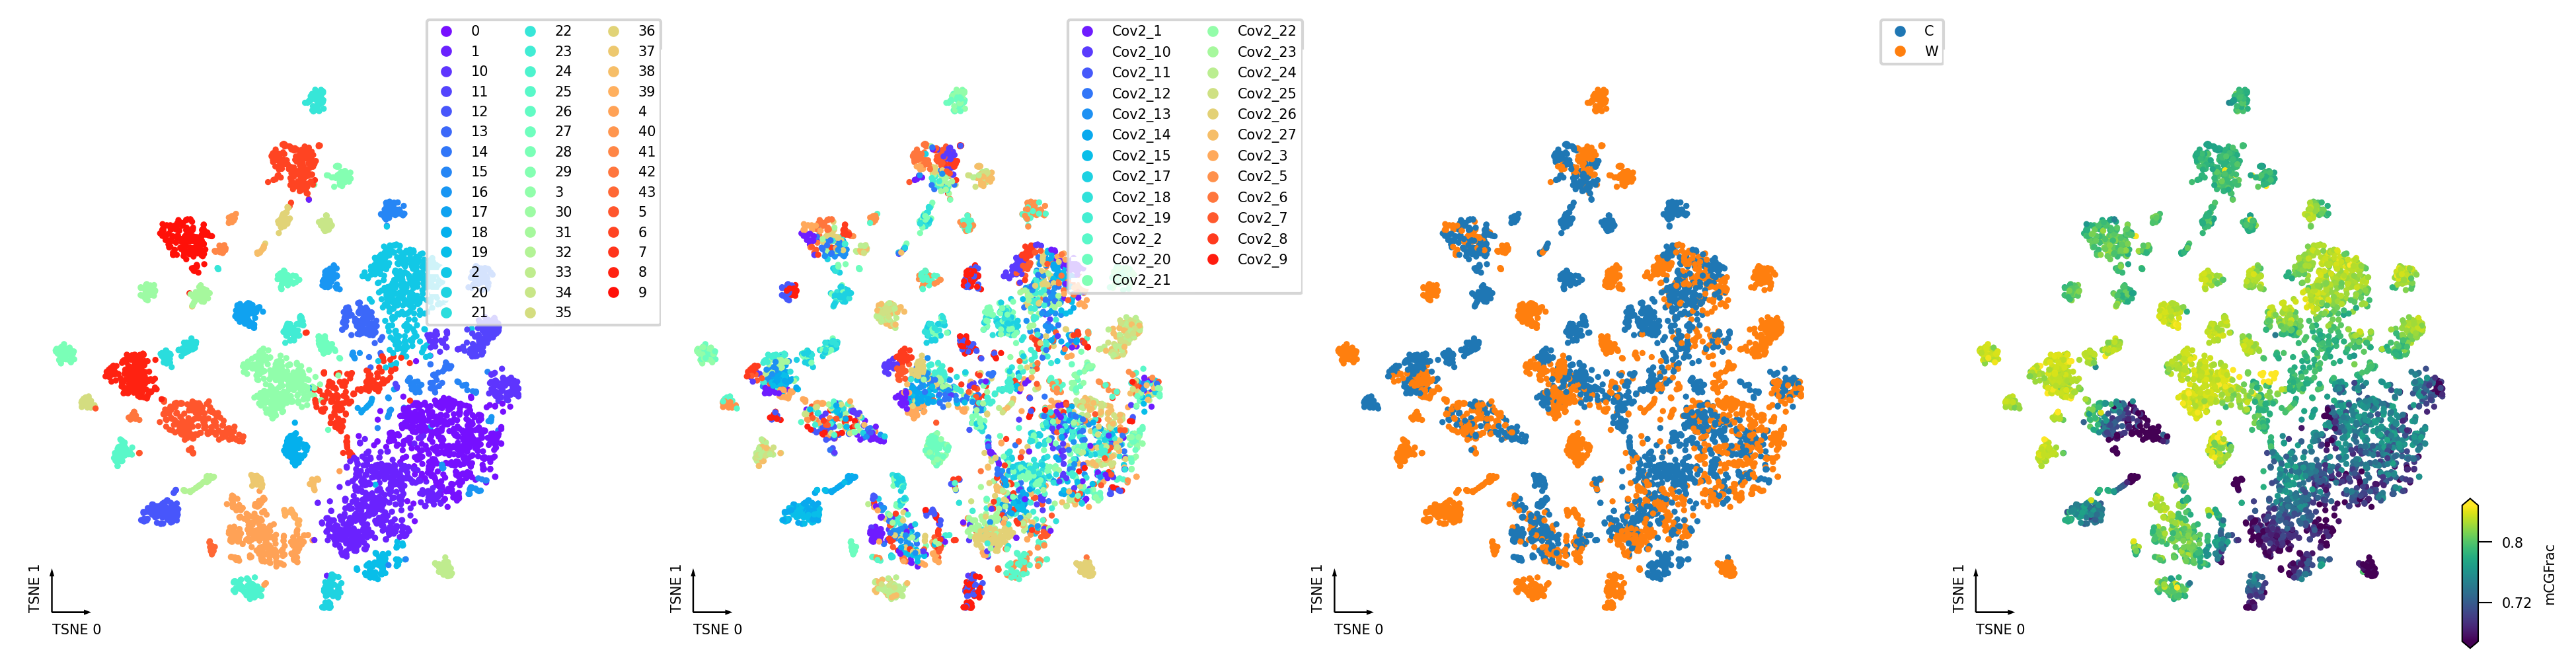

In [32]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=mcad.obs, ax=axes[0], coord_base='tsne', hue='leiden', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[1], coord_base='tsne', hue='Sample', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[2], coord_base='tsne', hue='condition', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=mcad.obs, ax=axes[3], coord_base='tsne', hue='mCGFrac', labelsize=5)


In [33]:
mcad.write_h5ad(f'COVID.All.TSNE.mcad')

/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Plate' as categorical
/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'PCRIndex' as categorical
/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_

# Harmony

In [34]:
sce.pp.harmony_integrate(mcad, ['Sample'], max_iter_harmony=30, random_state=0)
mcad.obsm['5kCG_u30hm'] = mcad.obsm['X_pca_harmony'].copy()

2022-06-09 16:40:22,579 - harmonypy - INFO - Iteration 1 of 30
2022-06-09 16:40:31,747 - harmonypy - INFO - Iteration 2 of 30
2022-06-09 16:40:40,932 - harmonypy - INFO - Iteration 3 of 30
2022-06-09 16:40:49,963 - harmonypy - INFO - Iteration 4 of 30
2022-06-09 16:40:53,860 - harmonypy - INFO - Iteration 5 of 30
2022-06-09 16:40:59,325 - harmonypy - INFO - Iteration 6 of 30
2022-06-09 16:41:03,217 - harmonypy - INFO - Iteration 7 of 30
2022-06-09 16:41:06,725 - harmonypy - INFO - Iteration 8 of 30
2022-06-09 16:41:10,599 - harmonypy - INFO - Iteration 9 of 30
2022-06-09 16:41:14,130 - harmonypy - INFO - Iteration 10 of 30
2022-06-09 16:41:18,024 - harmonypy - INFO - Converged after 10 iterations


In [35]:
sc.pp.neighbors(mcad, use_rep="5kCG_u30hm")
sc.tl.leiden(mcad, resolution=resolution)

In [36]:
tsne(mcad,
     obsm='5kCG_u30hm',
     metric='euclidean',
     exaggeration=-1,  # auto determined
     perplexity=30,
     n_jobs=-1)
dump_embedding(mcad, 'tsne')

In [37]:
mcad.obs['HM_tsne_0'] = mcad.obs['tsne_0']
mcad.obs['HM_tsne_1'] = mcad.obs['tsne_1']
mcad.obs['HM_leiden'] = mcad.obs['leiden']

mcad.obsm['5kCG_u30hm_tsne'] = mcad.obsm['X_tsne'].copy()

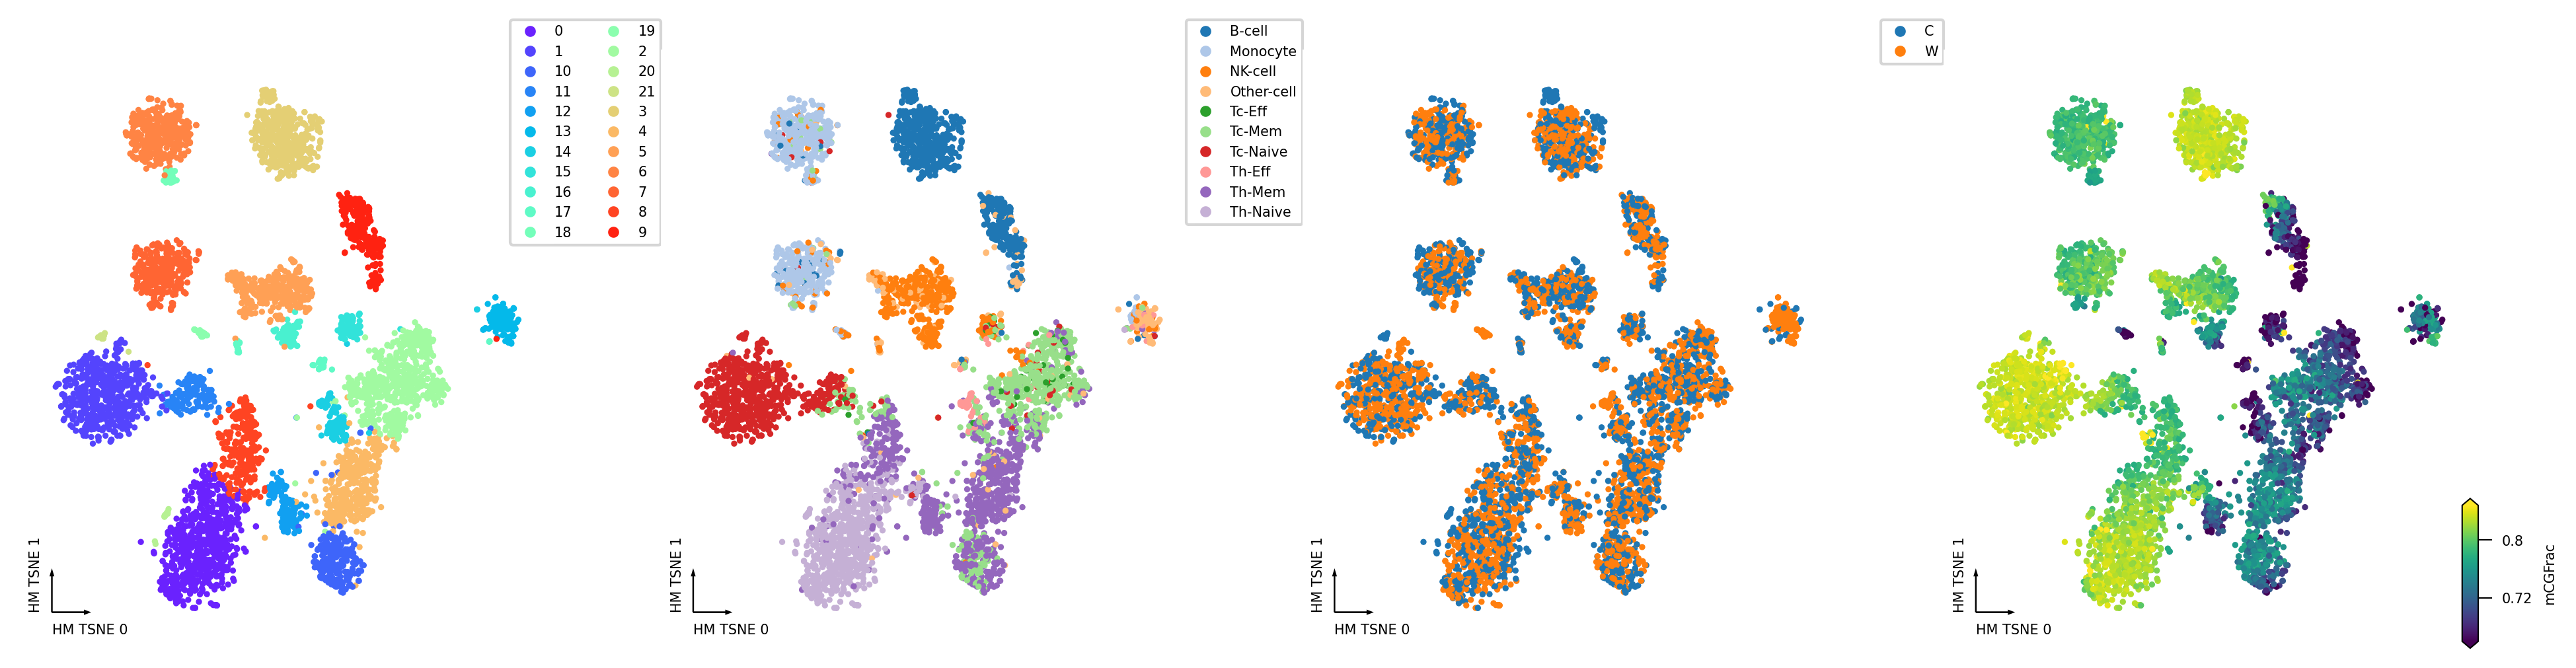

In [39]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=mcad.obs, ax=axes[0], coord_base='HM_tsne', hue='HM_leiden', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[1], coord_base='HM_tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[2], coord_base='HM_tsne', hue='condition', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=mcad.obs, ax=axes[3], coord_base='HM_tsne', hue='mCGFrac', labelsize=5)


In [40]:
mcad.write_h5ad("COVID.All.TSNE.HM.mcad")

# 3. cell type annotation

In [5]:
mcad = anndata.read_h5ad("COVID.All.TSNE.HM.mcad")

In [14]:
import xarray as xr
import pybedtools
import dask
from ALLCools.plot import *
from ALLCools.mcds import MCDS
import pathlib
import glob

In [15]:
gene_meta_path = '/gale/netapp/DoD/wenliang/database/ref/hg38/Annotation/gencode.v35.annotation.gene.withName.bed'
chrom_to_remove = ['chrM', 'chrX', 'chrY']

# change this to the paths to your MCDS files
mcds_path_list = glob.glob("/gale/netapp/DoD/wenliang/projects/05.COVID/02.clustering/00.data/MCDS/*.mcds")
obs_dim = 'cell'
var_dim = 'gene'

min_cov = 5

In [8]:
gene_meta = pd.read_csv(gene_meta_path, sep='\t', names=['chrom', 'start', 'end', 'gene_id', 'gene_name'], index_col=3)

genes_to_skip = set()

# skip smaller genes mostly covered by a larger gene, e.g., a miRNA within a protein coding gene.
# F=0.9 means > 90% of gene_b is overlapped with gene_a, in this case, we only keep gene_a for DMG test
gene_bed = pybedtools.BedTool.from_dataframe(
    gene_meta.reset_index()[['chrom', 'start', 'end', 'gene_id']])
mapped_bam = gene_bed.map(b=gene_bed, c=4, o='distinct', F=0.9)
for _, (*_, gene_a, gene_b_str) in mapped_bam.to_dataframe().iterrows():
    for gene_b in gene_b_str.split(','):
        if gene_b != gene_a:
            genes_to_skip.add(gene_b)

# remove certain chromosomes
genes_to_skip |= set(gene_meta.index[gene_meta['chrom'].isin(chrom_to_remove)])
use_features = gene_meta.index[~gene_meta.index.isin(genes_to_skip)]
print(f'{use_features.size} features remained')

36763 features remained


In [9]:
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    # still use all the cells to load MCDS
    mcds = MCDS.open(mcds_path_list, obs_dim=obs_dim, use_obs=metadata.index)

Feature gene mean cov across cells added in MCDS.coords['gene_cov_mean'].


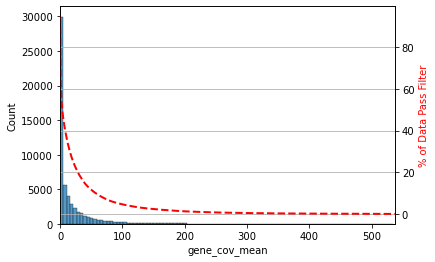

In [10]:
mcds.add_feature_cov_mean(var_dim=var_dim, obs_dim=obs_dim)

In [11]:
feature_cov_mean = mcds.coords[f'{var_dim}_cov_mean'].to_pandas()

In [12]:
use_features &= feature_cov_mean[feature_cov_mean > min_cov].index

print(f'{use_features.size} features remained')

22407 features remained


/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  """Entry point for launching an IPython kernel.


In [13]:
mcds.filter_feature_by_cov_mean(var_dim, min_cov=min_cov)

Before cov mean filter: 60656 gene
 After cov mean filter: 27934 gene 46.1%


<xarray.MCDS>
Dimensions:              (gene: 27934, cell: 19494, count_type: 2, chrom100k: 30895)
Coordinates: (12/13)
  * gene                 (gene) object 'ENSG00000279457' ... 'ENSG00000237917'
    gene_chrom           (gene) <U1 dask.array<chunksize=(2020,), meta=np.ndarray>
    gene_start           (gene) int32 dask.array<chunksize=(2020,), meta=np.ndarray>
    gene_end             (gene) int32 dask.array<chunksize=(2020,), meta=np.ndarray>
  * cell                 (cell) <U23 'Cov2_1_1-2-A17-G3' ... 'Cov2_9_2-5-K18-L9'
  * count_type           (count_type) <U3 'mc' 'cov'
    ...                   ...
    mc_type              <U3 'CGN'
    chrom100k_chrom      (chrom100k) <U1 dask.array<chunksize=(4096,), meta=np.ndarray>
  * chrom100k            (chrom100k) int32 0 1 2 3 4 ... 30891 30892 30893 30894
    chrom100k_bin_start  (chrom100k) int32 dask.array<chunksize=(4096,), meta=np.ndarray>
    chrom100k_bin_end    (chrom100k) int32 dask.array<chunksize=(4096,), meta=np.ndarray>
    gene_cov_mean        (gene) float64 5.017 61.03 8.558 ... 5.09 6.319 6.208
Data variables:
    gene_da              (cell, gene, count_type) int32 dask.array<chunksize=(3898, 2020, 1), meta=np.ndarray>
    chrom100k_da         (cell, chrom100k, count_type) int32 dask.array<chunksize=(3898, 4096, 1), meta=np.ndarray>
Attributes:
    obs_dim:  cell
    var_dim:  null

In [16]:
gene_frac_dir = pathlib.Path('gene_frac_raw')
gene_frac_dir.mkdir(exist_ok=True)

In [17]:
for mcds_path in mcds_path_list:
    output_path = gene_frac_dir / (pathlib.Path(mcds_path).name + f'{var_dim}_da_frac.mcds')
    if output_path.exists():
        continue
    print(f'Computaing gene mC fraction for {mcds_path}')
    mcds = MCDS.open(mcds_path, obs_dim=obs_dim)
    # remove non-related data
    del_das = []
    for da in mcds:
        if da != f'{var_dim}_da':
            del_das.append(da)
    for da in del_das:
        del mcds[da]
    mcds.load()
    mcds = mcds.sel({var_dim: use_features})
    mcds.add_mc_rate(var_dim=var_dim, normalize_per_cell=True, clip_norm_value=10)
    # use float32 to reduce file size and speedup IO
    mcds = mcds.rename({var_dim: 'gene', f'{var_dim}_da_frac': 'gene_da_frac'})
    mcds['gene_da_frac'].astype('float32').to_netcdf(output_path)

In [16]:
use_gene_meta = gene_meta.loc[use_features]
use_gene_meta.to_csv(gene_frac_dir / 'GeneMetadata.csv.gz')

In [18]:
Markers = ['CD38', 'CXCR5', 'CD34', 'CD80', 'TNFRSF13B', 'CD40', 'IGHM', 'CD5', 'MS4A1', 'CD24', 'CD79A', 'CXCR4', 'CD22', 'IGHD']\
        + ['CD14', 'CD36', 'CCR2', 'CD74', 'CLEC9A']\
        + ['NCAM1']\
        + ['MKI67']\
        + ['CD4', 'CD40LG', 'CD8A', 'CD8B', 'SELL', 'CCR7', 'NR4A1', 'CX3CR1', 'CD45RA', 'CD27', 'ITGAM']

In [19]:
gene_meta = pd.read_csv(f'{gene_frac_dir}/GeneMetadata.csv.gz', index_col=0)
gene_meta.index.name = 'gene_id'

name2id = dict(zip(gene_meta['gene_name'], gene_meta.index))
marker_gene_ids = [name2id[x] for x in Markers if x in name2id]

gene_frac_da = MCDS.open(f'{gene_frac_dir}/*_da_frac.mcds')[f'gene_da_frac']
gene_frac_da = gene_frac_da.expand_dims(dim={'mc_type': ['CGN']})
genes_data = gene_frac_da.sel(mc_type='CGN').sel(gene=marker_gene_ids).squeeze().to_pandas()
genes_data.columns = genes_data.columns.map(gene_meta['gene_name'])
genes_data

gene                    CD38     CXCR5      CD34      CD80  TNFRSF13B  \
cell                                                                    
Cov2_1_1-2-A17-G3   1.182667  0.819565  0.921662  1.068671   0.970762   
Cov2_1_1-2-A17-H16  0.431308  0.643774  0.553216  0.812672   1.261755   
Cov2_1_1-2-A17-G4   0.825093  0.894720  0.247732  1.157564   1.207159   
Cov2_1_1-2-A17-G15  1.043685  0.546026  1.068311  1.254832   0.595941   
Cov2_1_1-2-A17-G16  0.651374  0.836787  0.914059  0.681592   1.047308   
...                      ...       ...       ...       ...        ...   
Cov2_9_2-1-K18-L2   1.132954  1.238647  0.556859  1.207353   1.089772   
Cov2_9_2-5-K18-L10  1.069206  1.193842  1.117898  1.195401   1.016985   
Cov2_9_2-5-K18-L22  1.050477  1.173293  1.162263  1.108462   1.146593   
Cov2_9_2-5-K18-L21  1.156162  0.863624  0.627765  1.188909   1.195693   
Cov2_9_2-5-K18-L9   1.223487  1.161668  0.999922  1.217480   1.225498   

gene                    CD40      IGHM       CD5     MS4A1      CD24  ...  \
cell                                                                  ...   
Cov2_1_1-2-A17-G3   1.139658  1.017565  1.149565  0.887638  0.018819  ...   
Cov2_1_1-2-A17-H16  1.197671  1.000000  1.047391  0.728980  1.000000  ...   
Cov2_1_1-2-A17-G4   0.946493  1.183890  1.228048  0.786967  0.291286  ...   
Cov2_1_1-2-A17-G15  1.347967  0.980152  1.169083  0.732478  1.000000  ...   
Cov2_1_1-2-A17-G16  0.597048  1.000000  1.237786  1.150357  0.102617  ...   
...                      ...       ...       ...       ...       ...  ...   
Cov2_9_2-1-K18-L2   1.124879  1.227820  0.918378  1.138923  0.042396  ...   
Cov2_9_2-5-K18-L10  1.205423  1.222517  0.982901  1.158171  0.080530  ...   
Cov2_9_2-5-K18-L22  0.390983  1.000000  0.581409  1.078792  0.448529  ...   
Cov2_9_2-5-K18-L21  0.769067  1.041068  0.810537  1.094348  0.019632  ...   
Cov2_9_2-5-K18-L9   0.458383  1.242920  0.938618  1.216520  0.124509  ...   

gene                  CLEC9A     NCAM1     MKI67       CD4      CD8A  \
cell                                                                   
Cov2_1_1-2-A17-G3   0.812647  0.966380  1.187679  1.054407  0.174362   
Cov2_1_1-2-A17-H16  0.765500  0.864944  1.563165  0.930069  0.971223   
Cov2_1_1-2-A17-G4   1.075211  1.069889  0.972462  1.217590  1.013990   
Cov2_1_1-2-A17-G15  1.107738  0.936504  1.138700  1.144771  0.382880   
Cov2_1_1-2-A17-G16  0.854618  1.055407  1.494650  0.906487  0.802851   
...                      ...       ...       ...       ...       ...   
Cov2_9_2-1-K18-L2   0.798199  1.040178  1.016090  1.153874  1.012286   
Cov2_9_2-5-K18-L10  1.160269  0.979960  0.733947  1.039966  0.584799   
Cov2_9_2-5-K18-L22  0.812705  0.904128  1.129337  1.013281  0.272381   
Cov2_9_2-5-K18-L21  1.138336  1.016953  1.180838  0.857442  1.002210   
Cov2_9_2-5-K18-L9   1.203382  0.957305  1.031055  1.143383  0.316604   

gene                    CD8B      CCR7     NR4A1    CX3CR1     ITGAM  
cell                                                                  
Cov2_1_1-2-A17-G3   1.121282  0.940659  0.782345  1.097643  0.925347  
Cov2_1_1-2-A17-H16  1.058212  1.000000  0.815996  0.460681  1.464970  
Cov2_1_1-2-A17-G4   0.996556  0.175983  0.421500  1.119470  1.241466  
Cov2_1_1-2-A17-G15  1.282212  0.948539  0.628973  1.271544  0.928081  
Cov2_1_1-2-A17-G16  1.191233  1.056048  1.068395  0.934350  1.361113  
...                      ...       ...       ...       ...       ...  
Cov2_9_2-1-K18-L2   0.930528  0.599309  1.176939  1.051212  1.053743  
Cov2_9_2-5-K18-L10  1.055450  0.288036  0.459841  1.224175  1.000218  
Cov2_9_2-5-K18-L22  0.822480  0.589639  0.276185  1.083166  1.147558  
Cov2_9_2-5-K18-L21  1.122110  0.759191  0.407647  1.116909  0.860799  
Cov2_9_2-5-K18-L9   1.115697  0.316495  0.754470  0.721587  1.064483  

[19542 rows x 27 columns]

In [19]:
genes_data = genes_data.loc[mcad.obs.index].drop_duplicates()
genes_data = genes_data[~genes_data.index.duplicated(keep='first')]

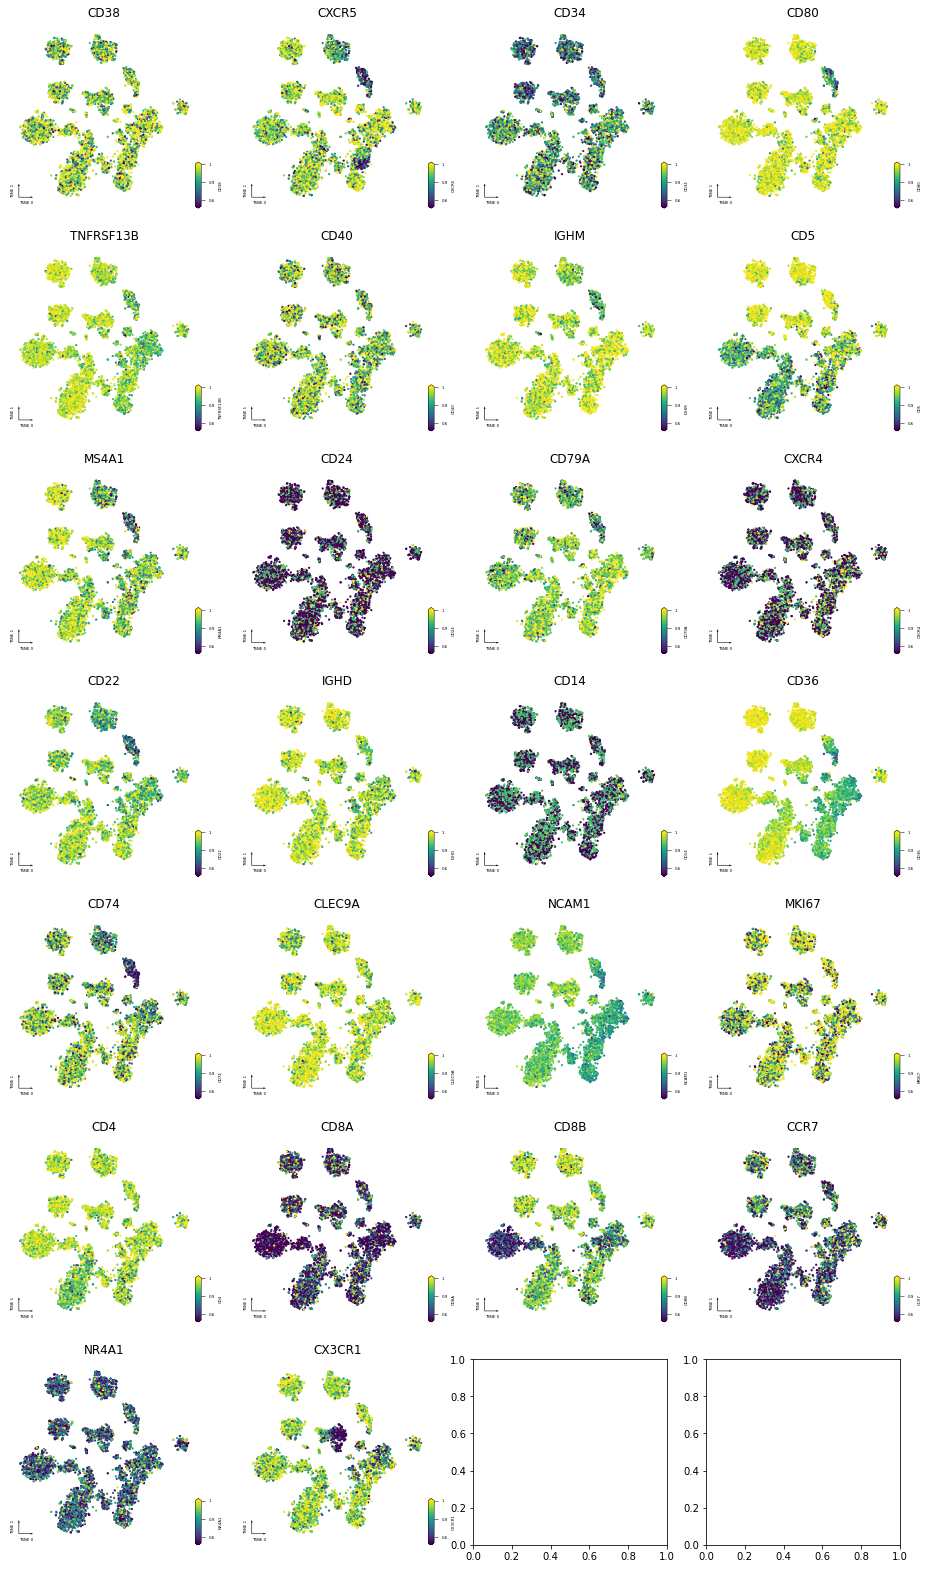

In [20]:
fig, axes = plt.subplots(7, 4, figsize=(16, 28))
axes = axes.flatten()
for i, (gene, data) in enumerate(genes_data.iteritems()):
    ax = axes[i]
    continuous_scatter(ax=ax,
                       data=mcad.obs,
                       hue=data,
                       coord_base='tsne',
                      hue_norm=[0.5, 1.2])
    ax.set_title(f'{data.name}')

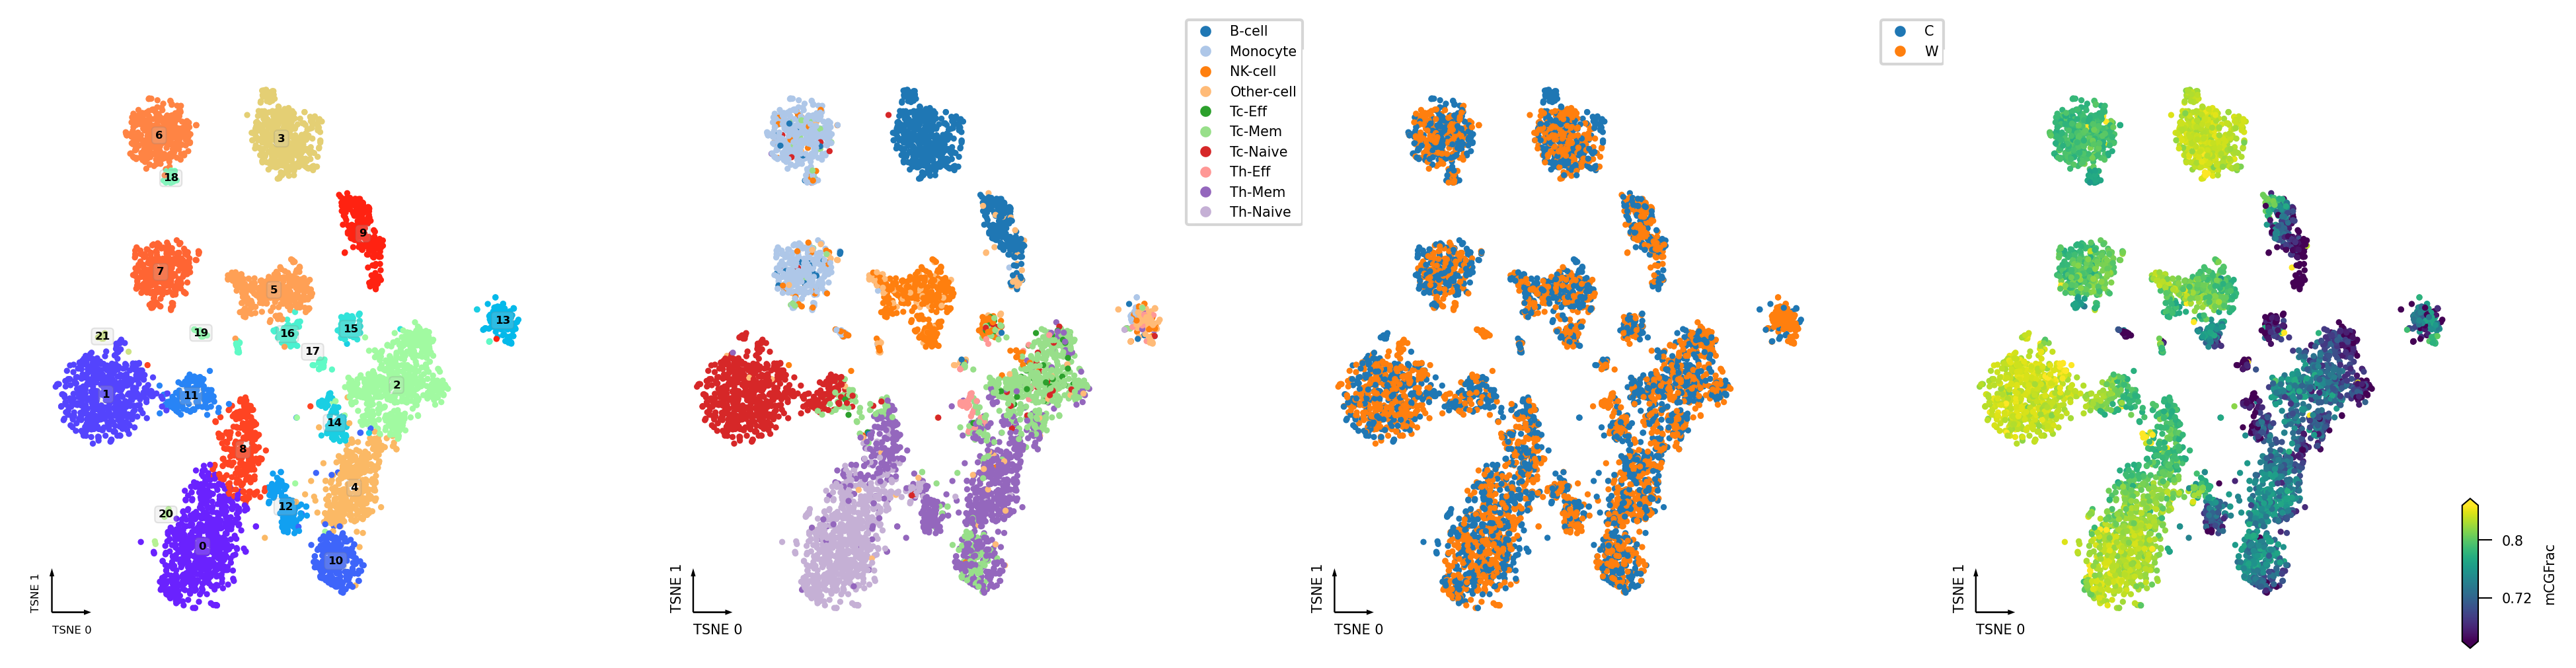

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=mcad.obs, ax=axes[0], coord_base='tsne', hue='HM_leiden', show_legend=False, 
#                         legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
                            text_anno="leiden")
_ = categorical_scatter(data=mcad.obs, ax=axes[1], coord_base='tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=mcad.obs, ax=axes[2], coord_base='tsne', hue='condition', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=mcad.obs, ax=axes[3], coord_base='tsne', hue='mCGFrac', labelsize=5)
plt.savefig("all_cluster.pdf")

In [8]:
leiden2celltype = {
                  5: 'NK-cell2',
                 16: 'NK-cell1',
                  6: 'Monocyte1',
                  7: 'Monocyte2',
                  3: 'B-Naive',
                  9: 'B-Mem'}

In [7]:
mcad = anndata.read_h5ad("COVID.All.TSNE.HM.Annotation.mcad")

In [9]:
mcad.obs['annotation'] = mcad.obs.apply(lambda row: leiden2celltype[int(row['HM_leiden'])] if int(row['HM_leiden']) in leiden2celltype else row['cell_type'], axis=1)

In [10]:
mcad.write_h5ad("COVID.All.TSNE.HM.Annotation.mcad")

/gale/netapp/DoD/wenliang/bin/miniconda3/envs/echo/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'annotation' as categorical


In [11]:
mcad.obs.to_csv("cell2cluster.csv")

In [2]:
cell2cluster = pd.read_csv("cell2cluster.csv")

In [3]:
cell_types = ['B-cell', 'Monocyte', 'NK-cell', 'Tc-Mem', 'Tc-Naive', 'Th-Mem', 'Th-Naive']

In [4]:
cell2cluster = cell2cluster[cell2cluster['cell_type'].isin(cell_types)]

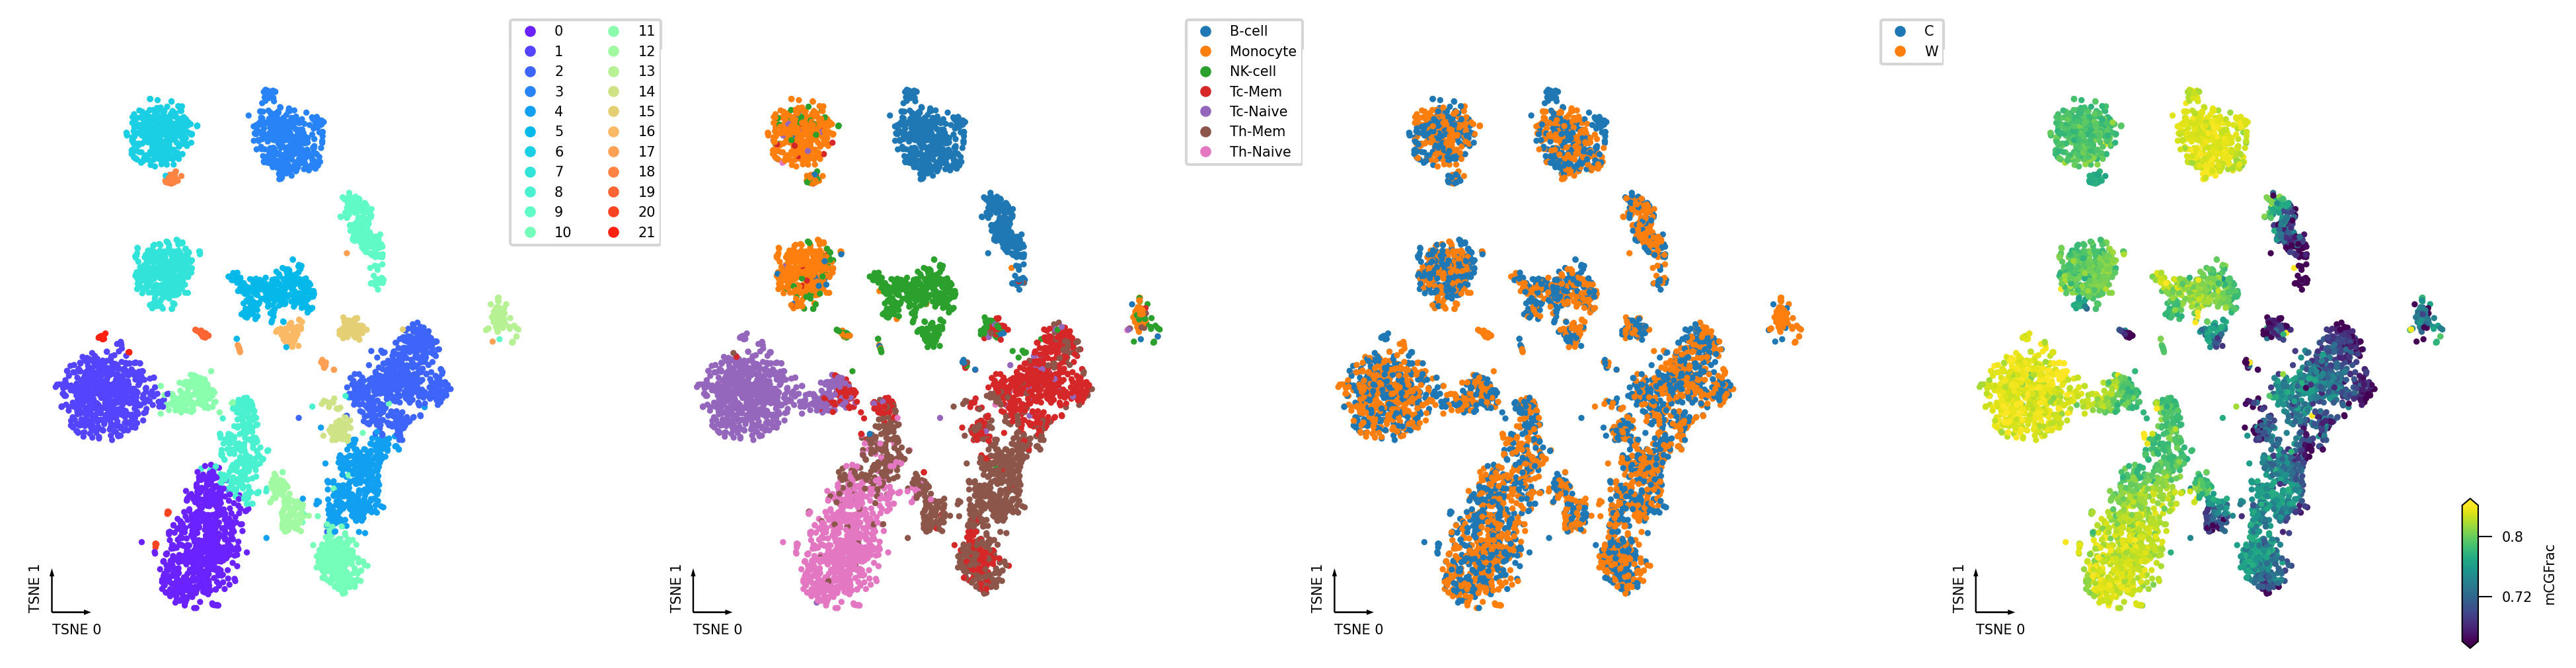

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
axes = axes.flatten()
_ = categorical_scatter(data=cell2cluster, ax=axes[0], coord_base='tsne', hue='HM_leiden', show_legend=True, 
                        legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
#                             text_anno="leiden")
_ = categorical_scatter(data=cell2cluster, ax=axes[1], coord_base='tsne', hue='cell_type', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = categorical_scatter(data=cell2cluster, ax=axes[2], coord_base='tsne', hue='condition', show_legend=True, 
                            legend_kws={'loc':1,'bbox_to_anchor':(1.2, 1.05)}, labelsize=5)
_ = continuous_scatter(data=cell2cluster, ax=axes[3], coord_base='tsne', hue='mCGFrac', labelsize=5)
plt.savefig("all_cluster.pdf")